In [ ]:
#drive connect
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler

# Load the dataset
df = pd.read_csv("/content/drive/MyDrive/research_Mine/final_usgs_imputed_data_with_temperature.csv")

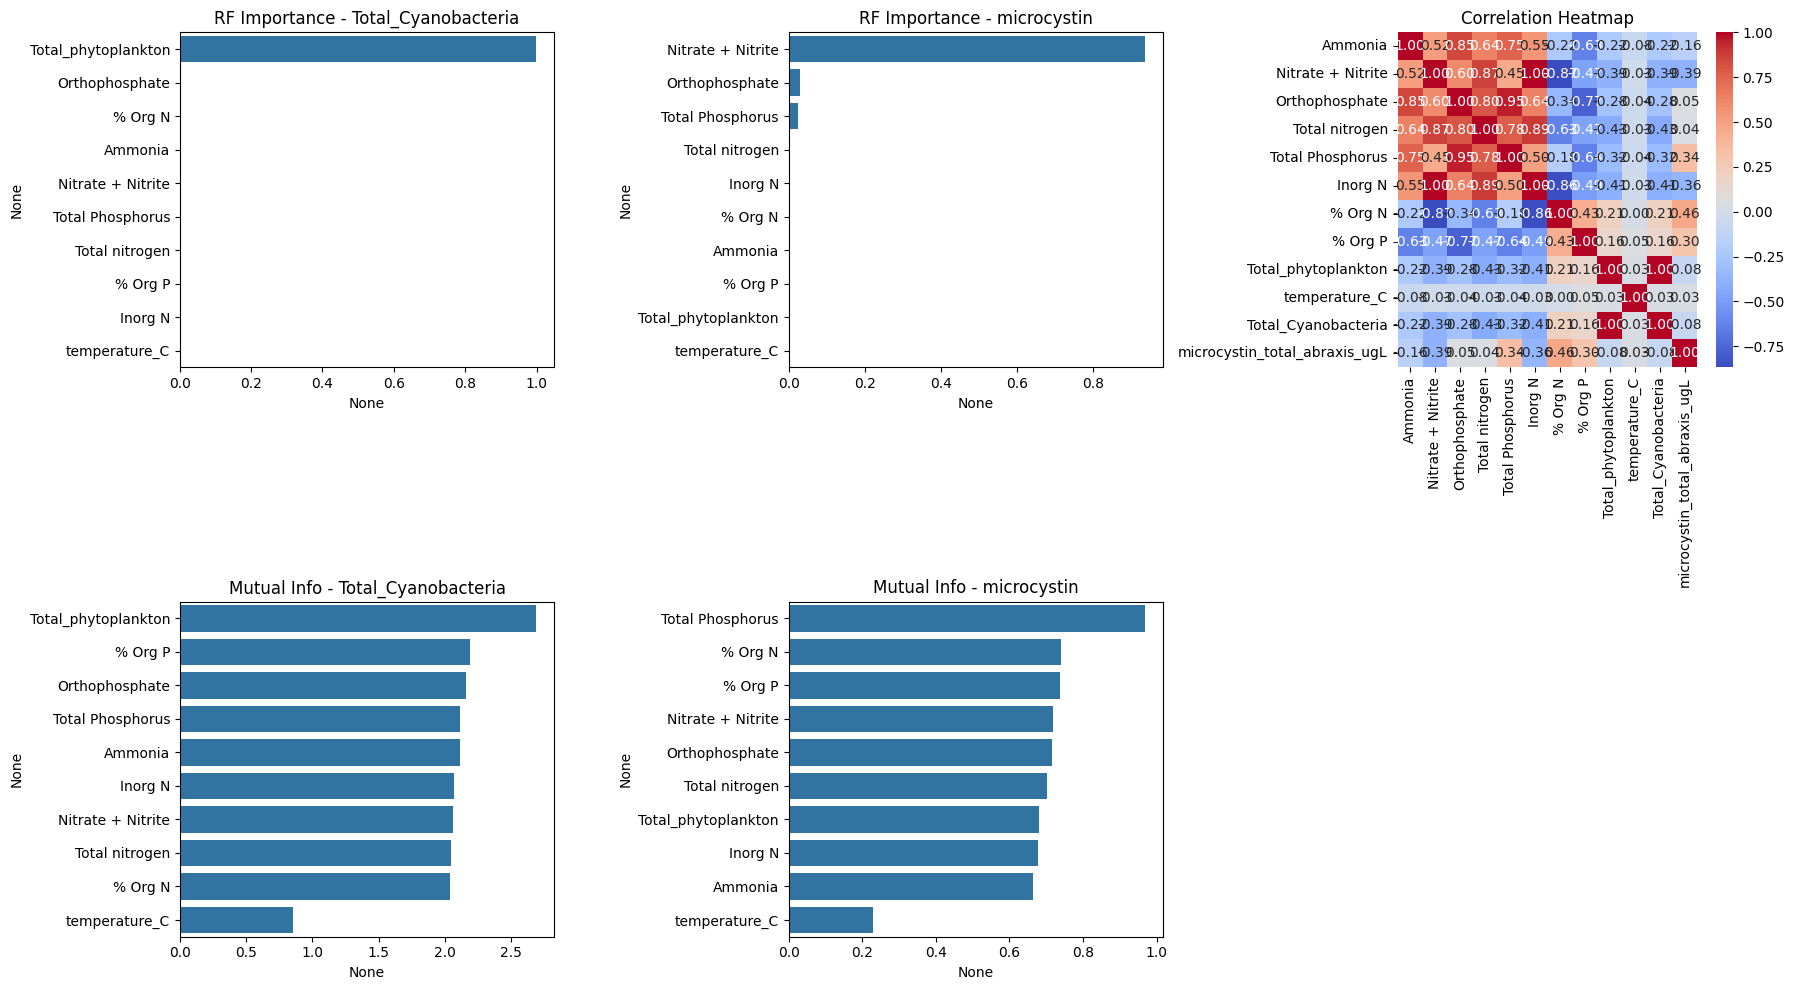

In [ ]:

# Convert dateTime to datetime format
df["dateTime"] = pd.to_datetime(df["dateTime"])

# Define features and target columns
features = [
    'Ammonia', 'Nitrate + Nitrite', 'Orthophosphate', 'Total nitrogen',
    'Total Phosphorus', 'Inorg N', '% Org N', '% Org P',
    'Total_phytoplankton', 'temperature_C'
]

target_cyano = 'Total_Cyanobacteria'
target_toxin = 'microcystin_total_abraxis_ugL'

# Normalize features for MI calculation
X_scaled = StandardScaler().fit_transform(df[features])
X = pd.DataFrame(X_scaled, columns=features)

# Fit Random Forest Regressors for both targets
rf_cyano = RandomForestRegressor(random_state=42).fit(X, df[target_cyano])
rf_toxin = RandomForestRegressor(random_state=42).fit(X, df[target_toxin])

# Extract RF feature importances
rf_importances_cyano = pd.Series(rf_cyano.feature_importances_, index=features)
rf_importances_toxin = pd.Series(rf_toxin.feature_importances_, index=features)

# Calculate Mutual Information
mi_cyano = pd.Series(mutual_info_regression(X, df[target_cyano], random_state=42), index=features)
mi_toxin = pd.Series(mutual_info_regression(X, df[target_toxin], random_state=42), index=features)

# Correlation analysis
corr = df[features + [target_cyano, target_toxin]].corr()
corr_cyano = corr[target_cyano][features].sort_values(ascending=False)
corr_toxin = corr[target_toxin][features].sort_values(ascending=False)

# Plotting
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Random Forest Importance
sns.barplot(x=rf_importances_cyano.sort_values(ascending=False),
            y=rf_importances_cyano.sort_values(ascending=False).index, ax=axes[0, 0])
axes[0, 0].set_title('RF Importance - Total_Cyanobacteria')

sns.barplot(x=rf_importances_toxin.sort_values(ascending=False),
            y=rf_importances_toxin.sort_values(ascending=False).index, ax=axes[0, 1])
axes[0, 1].set_title('RF Importance - microcystin')

# Correlation Heatmap
sns.heatmap(corr[features + [target_cyano, target_toxin]], annot=True, fmt=".2f",
            cmap='coolwarm', ax=axes[0, 2])
axes[0, 2].set_title("Correlation Heatmap")

# Mutual Information
sns.barplot(x=mi_cyano.sort_values(ascending=False),
            y=mi_cyano.sort_values(ascending=False).index, ax=axes[1, 0])
axes[1, 0].set_title('Mutual Info - Total_Cyanobacteria')

sns.barplot(x=mi_toxin.sort_values(ascending=False),
            y=mi_toxin.sort_values(ascending=False).index, ax=axes[1, 1])
axes[1, 1].set_title('Mutual Info - microcystin')

axes[1, 2].axis('off')

plt.tight_layout()
plt.show()


**Step1: Feature Analysis Using SHAP for Cyanobacteria and microcysstin **

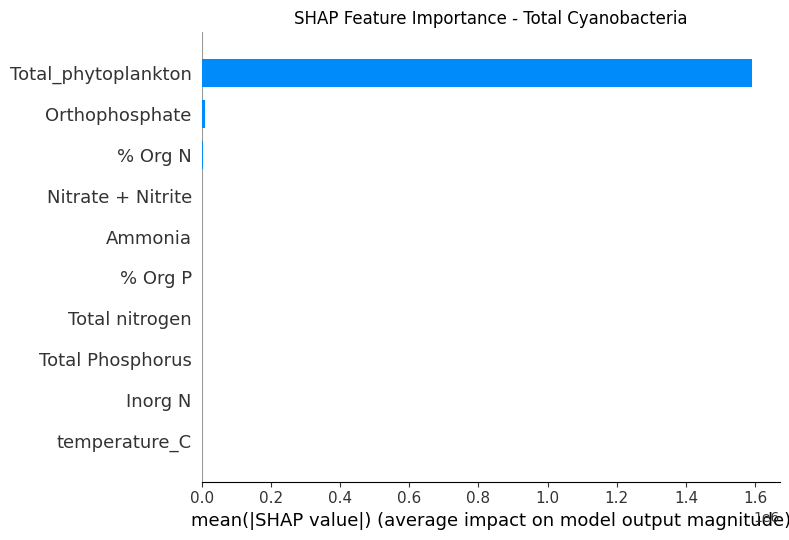

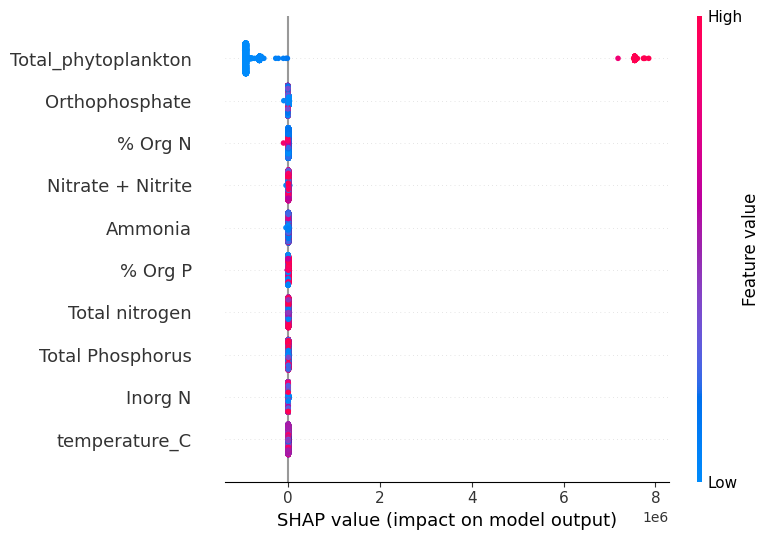

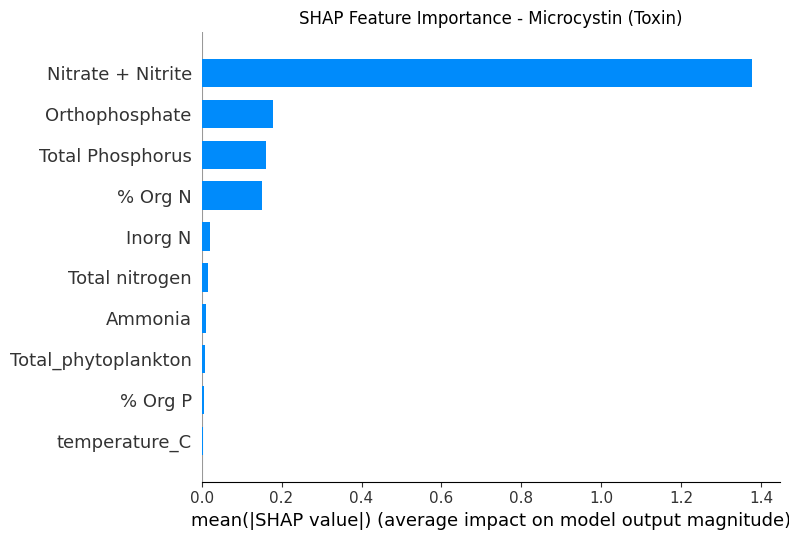

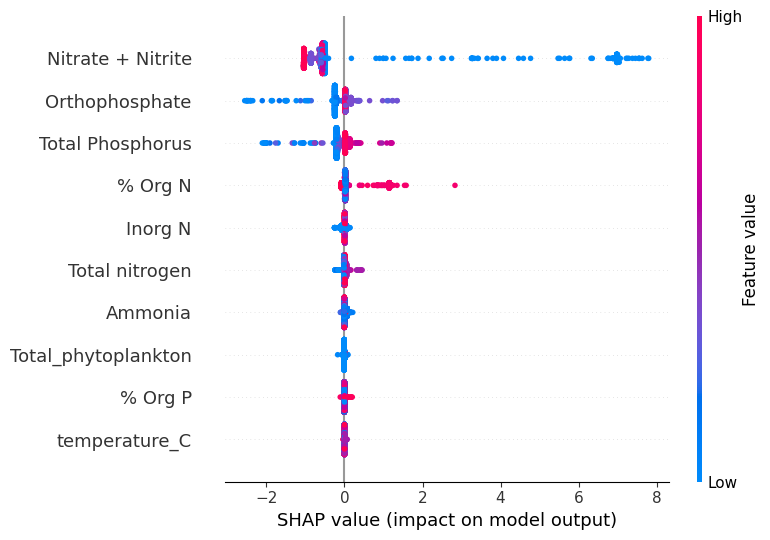

In [ ]:
import shap
import matplotlib.pyplot as plt

# Initialize SHAP explainer for the Random Forest (Cyanobacteria)
explainer_cyano = shap.TreeExplainer(rf_cyano)
shap_values_cyano = explainer_cyano.shap_values(X)

# SHAP Summary Plot for Total_Cyanobacteria
shap.summary_plot(shap_values_cyano, X, plot_type="bar", show=False)
plt.title("SHAP Feature Importance - Total Cyanobacteria")
plt.tight_layout()
plt.show()

# Beeswarm plot for detailed feature impact
shap.summary_plot(shap_values_cyano, X)

# Repeat for microcystin model
explainer_toxin = shap.TreeExplainer(rf_toxin)
shap_values_toxin = explainer_toxin.shap_values(X)

# SHAP Summary Plot for microcystin
shap.summary_plot(shap_values_toxin, X, plot_type="bar", show=False)
plt.title("SHAP Feature Importance - Microcystin (Toxin)")
plt.tight_layout()
plt.show()

# Beeswarm plot for microcystin
shap.summary_plot(shap_values_toxin, X)

**Step 2 Forecasting Plan**

**Forecast for site RR5:**
1.   Total_Cyanobacteria
2.   microcystin_total_abraxis_ugL

**Forecast Horizons:**
*   5-day
*   10-day
*   30-day (daily)










**Models to be Used:**

---


1.   ARIMA/SARIMA	Baseline model, strong for linear + seasonal data
2.   Prophet	      Handles seasonality, holidays, missing dates well

3.   LSTM	Deep learning, good for nonlinear dependencies
4.   XGBoost	Handles engineered lag/rolling features like a pro



**ARIMA Forecasting **

In [ ]:
df.columns

Index(['dateTime', 'site_no', 'site_abbreviation', 'Individual', 'sample_time',
       'microcystin_total_abraxis_ugL', 'Ammonia', 'Nitrate + Nitrite',
       'Orthophosphate', 'Total nitrogen', 'Total Phosphorus', 'Inorg N',
       '% Org N', '% Org P', 'Total_Cyanobacteria', 'Total_phytoplankton',
       'temperature_C'],
      dtype='object')

PROPHET (Facebook’s time series library)

In [ ]:
!pip install prophet


In [ ]:
df.columns

Index(['dateTime', 'site_no', 'site_abbreviation', 'Individual', 'sample_time',
       'microcystin_total_abraxis_ugL', 'Ammonia', 'Nitrate + Nitrite',
       'Orthophosphate', 'Total nitrogen', 'Total Phosphorus', 'Inorg N',
       '% Org N', '% Org P', 'Total_Cyanobacteria', 'Total_phytoplankton',
       'temperature_C'],
      dtype='object')

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5kzql6nf/w1zd_rt4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5kzql6nf/xtxwyee7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63102', 'data', 'file=/tmp/tmp5kzql6nf/w1zd_rt4.json', 'init=/tmp/tmp5kzql6nf/xtxwyee7.json', 'output', 'file=/tmp/tmp5kzql6nf/prophet_modelqv_q2oh_/prophet_model-20250421004750.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:47:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:47:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



✅ Prophet Forecast Evaluation (Total_Cyanobacteria at RR5, Last 30 Days):
MAE:  247.03
RMSE: 483.85
R²:   -0.095
MAPE: inf%


<ipython-input-21-a39eae58e9d0>:53: UserWarning: Glyph 127744 (\N{CYCLONE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127744 (\N{CYCLONE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


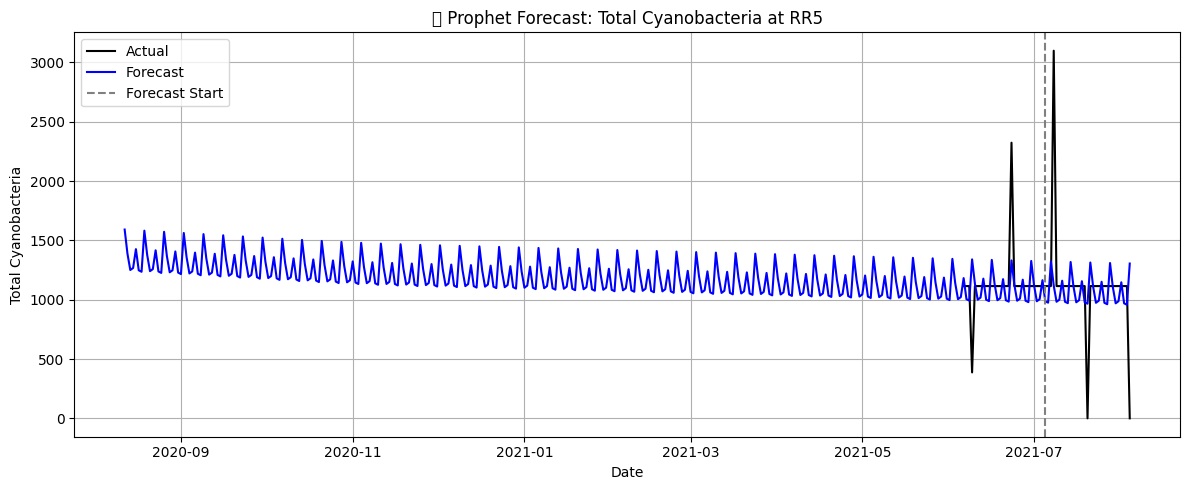

In [ ]:
# STEP 1: Setup and Load
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load your dataset
df = pd.read_csv("/content/drive/MyDrive/research_Mine/final_usgs_imputed_data_with_temperature.csv", parse_dates=["dateTime"])

# Filter for RR5 and drop missing values
df_rr5 = df[df["site_abbreviation"] == "RR5"][["dateTime", "Total_Cyanobacteria"]].dropna()

# Prophet requires 'ds' and 'y' column names
df_prophet = df_rr5.rename(columns={"dateTime": "ds", "Total_Cyanobacteria": "y"}).sort_values("ds")

# STEP 2: Train/test split (last 30 days as test set)
train = df_prophet[:-30]
test = df_prophet[-30:]

# STEP 3: Fit Prophet
model = Prophet()
model.fit(train)

# STEP 4: Forecast next 30 days
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

# STEP 5: Evaluation on test set
forecast_eval = forecast[["ds", "yhat"]].merge(test, on="ds", how="right")

mae = mean_absolute_error(forecast_eval["y"], forecast_eval["yhat"])
rmse = np.sqrt(mean_squared_error(forecast_eval["y"], forecast_eval["yhat"])) # Calculate RMSE by taking the square root of MSEr2 = r2_score(forecast_eval["y"], forecast_eval["yhat"])
r2 = r2_score(forecast_eval["y"], forecast_eval["yhat"])
mape = np.mean(np.abs((forecast_eval["y"] - forecast_eval["yhat"]) / forecast_eval["y"])) * 100

print(f"\n✅ Prophet Forecast Evaluation (Total_Cyanobacteria at RR5, Last 30 Days):")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.3f}")
print(f"MAPE: {mape:.2f}%")

# STEP 6: Plotting (last 60 days to show transition)
plt.figure(figsize=(12, 5))
plt.plot(df_prophet["ds"][-60:], df_prophet["y"].iloc[-60:], label="Actual", color="black")
plt.plot(forecast["ds"], forecast["yhat"], label="Forecast", color="blue")
plt.axvline(x=train["ds"].iloc[-1], color="gray", linestyle="--", label="Forecast Start")
plt.title("🌀 Prophet Forecast: Total Cyanobacteria at RR5")
plt.xlabel("Date")
plt.ylabel("Total Cyanobacteria")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
print("📅 Forecast for next 5 days:")
print(forecast[["ds", "yhat"]].tail(30).head(5))

print("\n📅 Forecast for next 10 days:")
print(forecast[["ds", "yhat"]].tail(30).head(10))

print("\n📅 Forecast for next 30 days:")
print(forecast[["ds", "yhat"]].tail(30))


📅 Forecast for next 5 days:
            ds         yhat
328 2021-07-06   974.942050
329 2021-07-07  1322.039537
330 2021-07-08  1118.262563
331 2021-07-09   982.478007
332 2021-07-10  1000.052497

📅 Forecast for next 10 days:
            ds         yhat
328 2021-07-06   974.942050
329 2021-07-07  1322.039537
330 2021-07-08  1118.262563
331 2021-07-09   982.478007
332 2021-07-10  1000.052497
333 2021-07-11  1159.632979
334 2021-07-12   982.272932
335 2021-07-13   970.555696
336 2021-07-14  1317.653183
337 2021-07-15  1113.876209

📅 Forecast for next 30 days:
            ds         yhat
328 2021-07-06   974.942050
329 2021-07-07  1322.039537
330 2021-07-08  1118.262563
331 2021-07-09   982.478007
332 2021-07-10  1000.052497
333 2021-07-11  1159.632979
334 2021-07-12   982.272932
335 2021-07-13   970.555696
336 2021-07-14  1317.653183
337 2021-07-15  1113.876209
338 2021-07-16   978.091653
339 2021-07-17   995.666143
340 2021-07-18  1155.246625
341 2021-07-19   977.886578
342 2021-07-20  

<ipython-input-23-5ea10088ee7a>:11: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


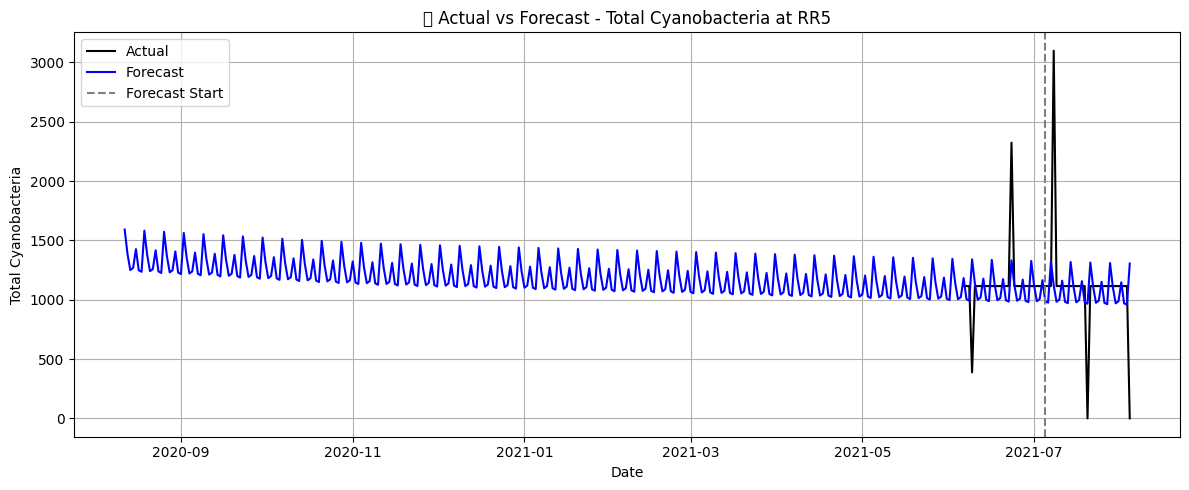

<ipython-input-23-5ea10088ee7a>:31: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


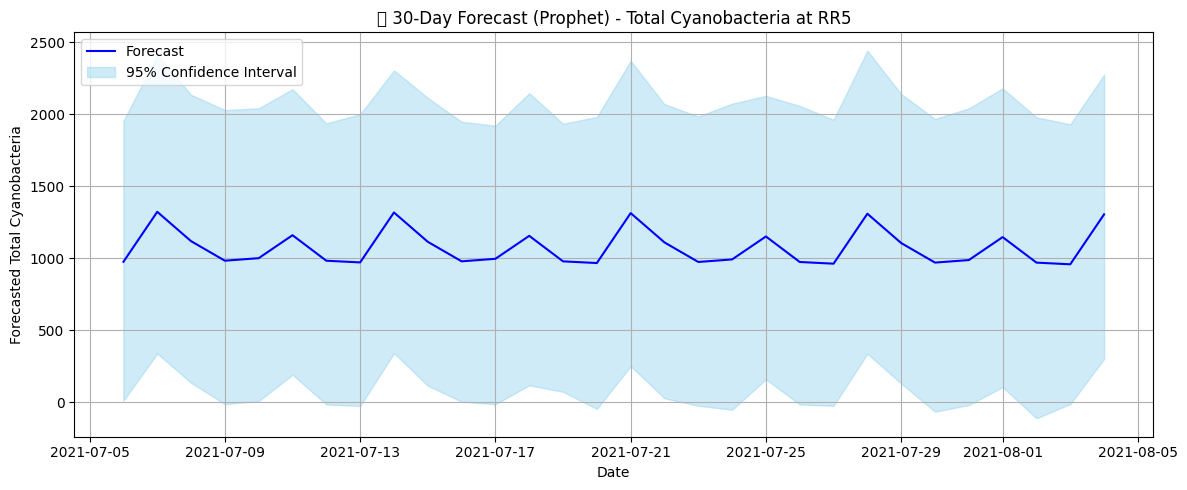

In [ ]:
# 1. Actual vs Forecast (last 60 days)
plt.figure(figsize=(12, 5))
plt.plot(df_prophet["ds"][-60:], df_prophet["y"].iloc[-60:], label="Actual", color="black")
plt.plot(forecast["ds"], forecast["yhat"], label="Forecast", color="blue")
plt.axvline(x=train["ds"].iloc[-1], color="gray", linestyle="--", label="Forecast Start")
plt.title("📊 Actual vs Forecast - Total Cyanobacteria at RR5")
plt.xlabel("Date")
plt.ylabel("Total Cyanobacteria")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Forecast Only (Next 30 Days)
forecast_next30 = forecast.tail(30)

plt.figure(figsize=(12, 5))
plt.plot(forecast_next30["ds"], forecast_next30["yhat"], label="Forecast", color="blue")
plt.fill_between(
    forecast_next30["ds"],
    forecast_next30["yhat_lower"],
    forecast_next30["yhat_upper"],
    color="skyblue", alpha=0.4,
    label="95% Confidence Interval"
)
plt.title("🔮 30-Day Forecast (Prophet) - Total Cyanobacteria at RR5")
plt.xlabel("Date")
plt.ylabel("Forecasted Total Cyanobacteria")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


First plot = how well Prophet fits past data + where it starts forecasting

Second plot = clean look at next 30 days only with confidence intervals



 Microcystin Forecast with Prophet

In [ ]:
# STEP 1: Load & Prepare
df_micro = df[["dateTime", "site_abbreviation", "microcystin_total_abraxis_ugL"]].dropna()
df_micro_rr5 = df_micro[df_micro["site_abbreviation"] == "RR5"].sort_values("dateTime")

# Rename for Prophet
df_prophet_micro = df_micro_rr5.rename(columns={
    "dateTime": "ds",
    "microcystin_total_abraxis_ugL": "y"
})

# STEP 2: Train/test split (last 30 days)
train_micro = df_prophet_micro[:-30]
test_micro = df_prophet_micro[-30:]

# STEP 3: Fit Prophet
model_micro = Prophet()
model_micro.fit(train_micro)

# STEP 4: Forecast next 30 days
future_micro = model_micro.make_future_dataframe(periods=30)
forecast_micro = model_micro.predict(future_micro)

# STEP 5: Evaluation
forecast_eval_micro = forecast_micro[["ds", "yhat"]].merge(test_micro, on="ds", how="right")

mae_micro = mean_absolute_error(forecast_eval_micro["y"], forecast_eval_micro["yhat"])
rmse_micro = mean_squared_error(forecast_eval_micro["y"], forecast_eval_micro["yhat"])
r2_micro = r2_score(forecast_eval_micro["y"], forecast_eval_micro["yhat"])
mape_micro = np.mean(np.abs((forecast_eval_micro["y"] - forecast_eval_micro["yhat"]) / forecast_eval_micro["y"])) * 100

print(f"\n✅ Prophet Forecast Evaluation (Microcystin at RR5, Last 30 Days):")
print(f"MAE:  {mae_micro:.3f}")
print(f"RMSE: {rmse_micro:.3f}")
print(f"R²:   {r2_micro:.3f}")
print(f"MAPE: {mape_micro:.2f}%")


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



✅ Prophet Forecast Evaluation (Microcystin at RR5, Last 30 Days):
MAE:  0.000
RMSE: 0.000
R²:   1.000
MAPE: 0.00%


<ipython-input-28-7eb5f5926fce>:10: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


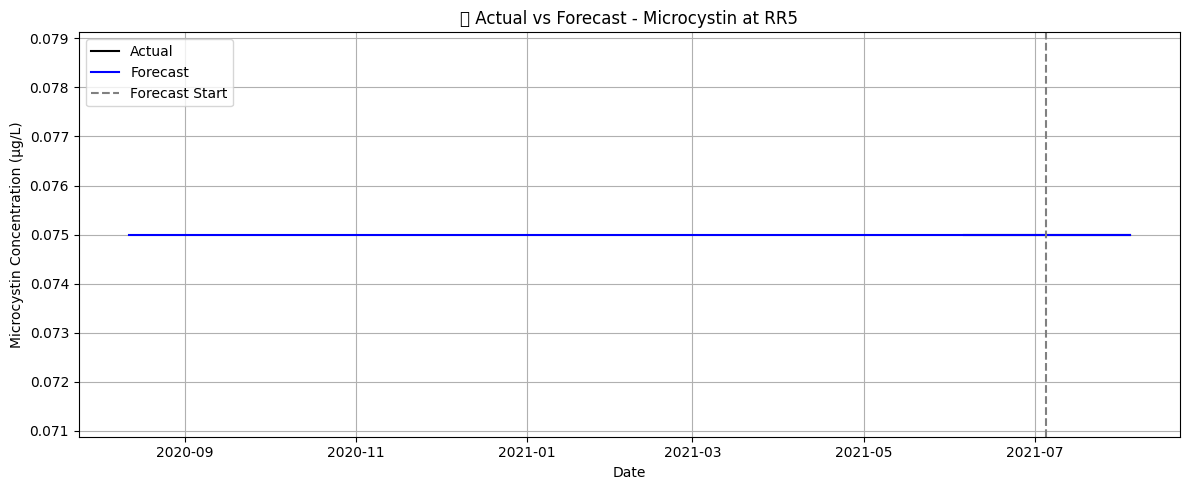

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(df_prophet_micro["ds"][-60:], df_prophet_micro["y"].iloc[-60:], label="Actual", color="black")
plt.plot(forecast_micro["ds"], forecast_micro["yhat"], label="Forecast", color="blue")
plt.axvline(x=train_micro["ds"].iloc[-1], color="gray", linestyle="--", label="Forecast Start")
plt.title("📊 Actual vs Forecast - Microcystin at RR5")
plt.xlabel("Date")
plt.ylabel("Microcystin Concentration (μg/L)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


<ipython-input-29-46b8767356cb>:17: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


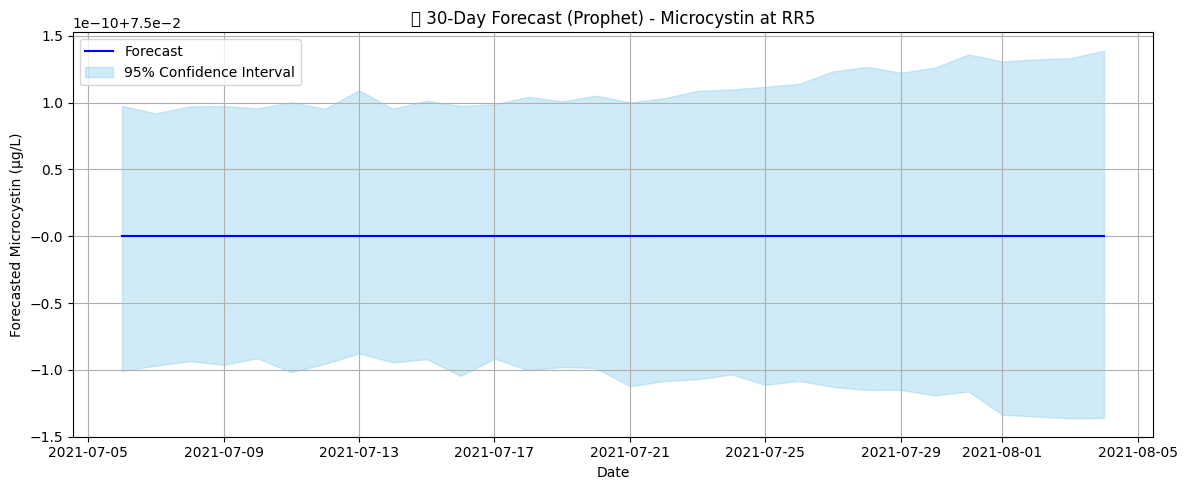

In [ ]:
forecast_next30_micro = forecast_micro.tail(30)

plt.figure(figsize=(12, 5))
plt.plot(forecast_next30_micro["ds"], forecast_next30_micro["yhat"], label="Forecast", color="blue")
plt.fill_between(
    forecast_next30_micro["ds"],
    forecast_next30_micro["yhat_lower"],
    forecast_next30_micro["yhat_upper"],
    color="skyblue", alpha=0.4,
    label="95% Confidence Interval"
)
plt.title("🔮 30-Day Forecast (Prophet) - Microcystin at RR5")
plt.xlabel("Date")
plt.ylabel("Forecasted Microcystin (μg/L)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


LSTM (deep learning time series)

XGBoost (boosted tree regression)

Input: Past 30 days to predict the next 1 day (rolling)

Forecast horizon: 30 days ahead (you can easily extend to 5, 10)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import xgboost as xgb

# Load data
df = pd.read_csv("/content/drive/MyDrive/research_Mine/final_usgs_imputed_data_with_temperature.csv", parse_dates=["dateTime"])
df_rr5 = df[df["site_abbreviation"] == "RR5"].sort_values("dateTime").reset_index(drop=True)

# Function: create rolling window dataset
def create_sequences(data, window_size=30):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)


1. LSTM for Cyanobacteria and Microcystin

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step

📈 LSTM Results for Total Cyanobacteria:
MAE: 196.45395622356162
RMSE: 467.725153295087
R²: -0.022833243056829877


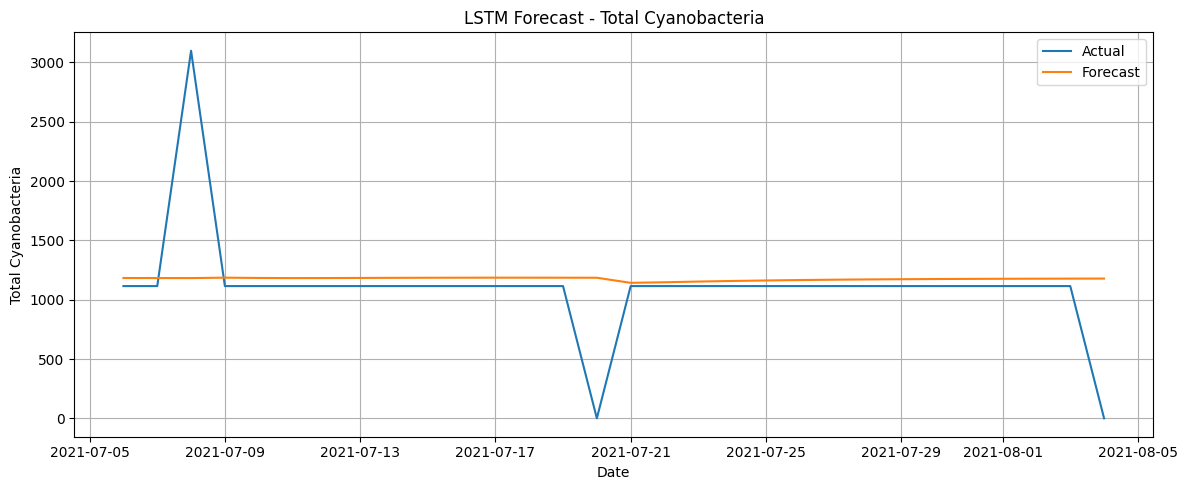

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step

📈 LSTM Results for Microcystin:
MAE: 2.980232241545089e-09
RMSE: 2.9802322415450884e-09
R²: -4.611686027017322e+16


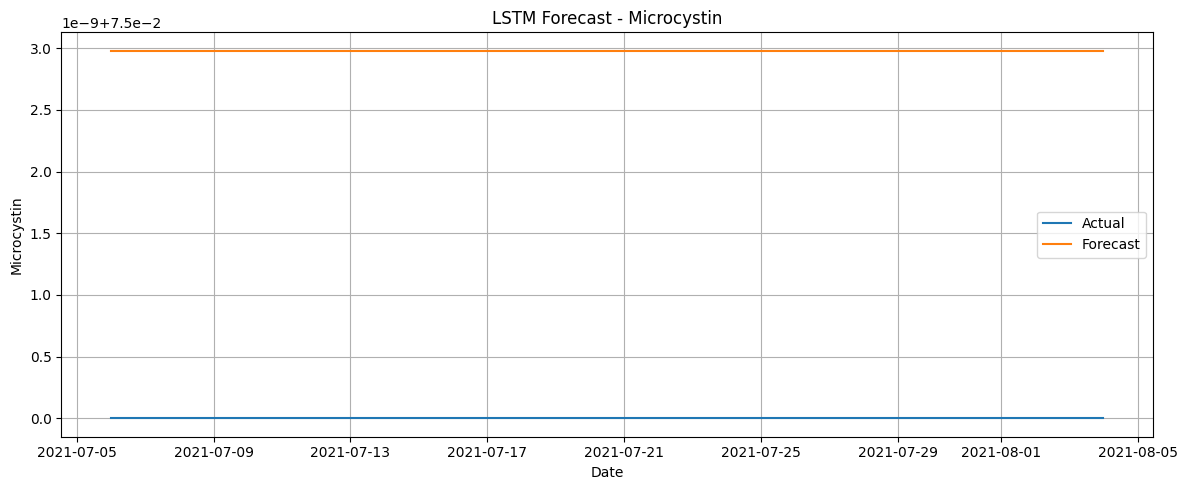

In [ ]:
def forecast_lstm(target_col, label):
    series = df_rr5[[target_col, "dateTime"]].dropna()
    scaler = MinMaxScaler()
    scaled_values = scaler.fit_transform(series[[target_col]])

    X, y = create_sequences(scaled_values, 30)
    X = X.reshape((X.shape[0], X.shape[1], 1))

    # Train/test split (last 30 days test)
    split_idx = -30
    X_train, y_train = X[:split_idx], y[:split_idx]
    X_test, y_test = X[split_idx:], y[split_idx:]

    model = Sequential([
        LSTM(50, activation='relu', input_shape=(30, 1)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=50, verbose=0)

    y_pred_scaled = model.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred_scaled)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Metrics
    print(f"\n📈 LSTM Results for {label}:")
    print("MAE:", mean_absolute_error(y_test_rescaled, y_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_test_rescaled, y_pred)))
    print("R²:", r2_score(y_test_rescaled, y_pred))

    # Plot
    plt.figure(figsize=(12,5))
    plt.plot(series["dateTime"][-30:], y_test_rescaled, label="Actual")
    plt.plot(series["dateTime"][-30:], y_pred, label="Forecast")
    plt.title(f"LSTM Forecast - {label}")
    plt.xlabel("Date")
    plt.ylabel(label)
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

# Run LSTM Forecasts
forecast_lstm("Total_Cyanobacteria", "Total Cyanobacteria")
forecast_lstm("microcystin_total_abraxis_ugL", "Microcystin")


⚡ 2. XGBoost for Cyanobacteria and Microcystin


📊 XGBoost Results for Total Cyanobacteria:
MAE: 181.83122169049346
RMSE: 501.4170063979075
R²: -0.17549693739657135


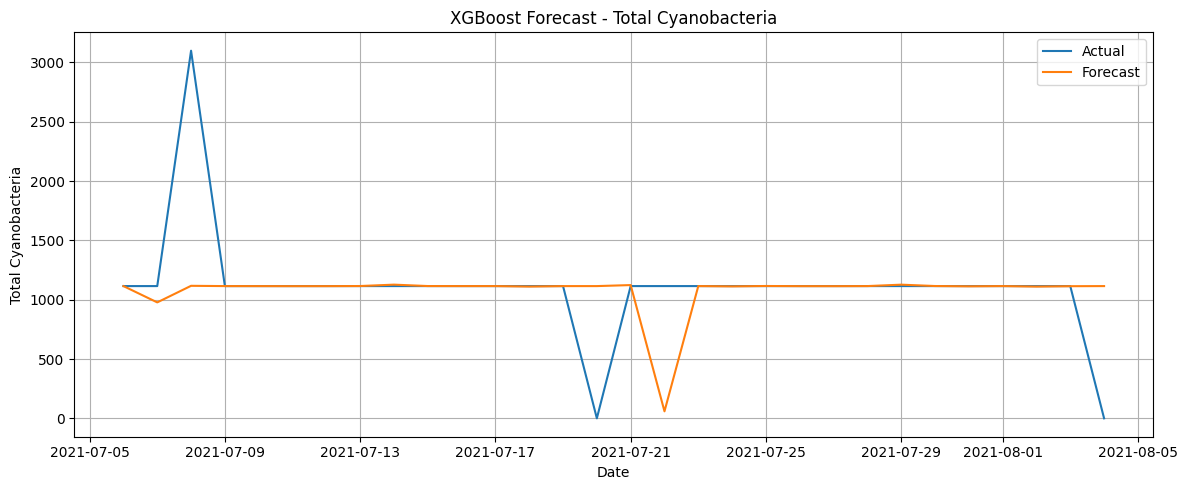


📊 XGBoost Results for Microcystin:
MAE: 2.980232241545089e-09
RMSE: 2.9802322415450884e-09
R²: -4.611686027017322e+16


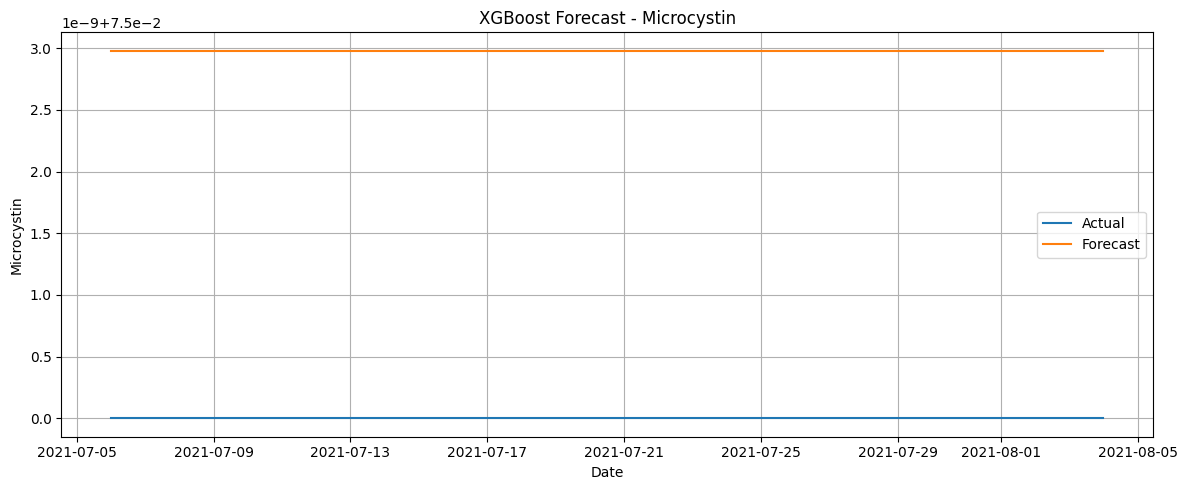

In [ ]:
def forecast_xgboost(target_col, label):
    series = df_rr5[["dateTime", target_col]].dropna().reset_index(drop=True)
    series["day"] = range(len(series))  # Simple numeric time

    # Create lag features (past 30 days)
    for lag in range(1, 31):
        series[f"lag_{lag}"] = series[target_col].shift(lag)
    series = series.dropna()

    # Split train/test
    train = series[:-30]
    test = series[-30:]

    X_train = train[[f"lag_{i}" for i in range(1, 31)]]
    y_train = train[target_col]
    X_test = test[[f"lag_{i}" for i in range(1, 31)]]
    y_test = test[target_col]

    model = xgb.XGBRegressor(n_estimators=100)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Metrics
    print(f"\n📊 XGBoost Results for {label}:")
    print("MAE:", mean_absolute_error(y_test, y_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
    print("R²:", r2_score(y_test, y_pred))

    # Plot
    plt.figure(figsize=(12,5))
    plt.plot(test["dateTime"], y_test, label="Actual")
    plt.plot(test["dateTime"], y_pred, label="Forecast")
    plt.title(f"XGBoost Forecast - {label}")
    plt.xlabel("Date")
    plt.ylabel(label)
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

# Run XGBoost Forecasts
forecast_xgboost("Total_Cyanobacteria", "Total Cyanobacteria")
forecast_xgboost("microcystin_total_abraxis_ugL", "Microcystin")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


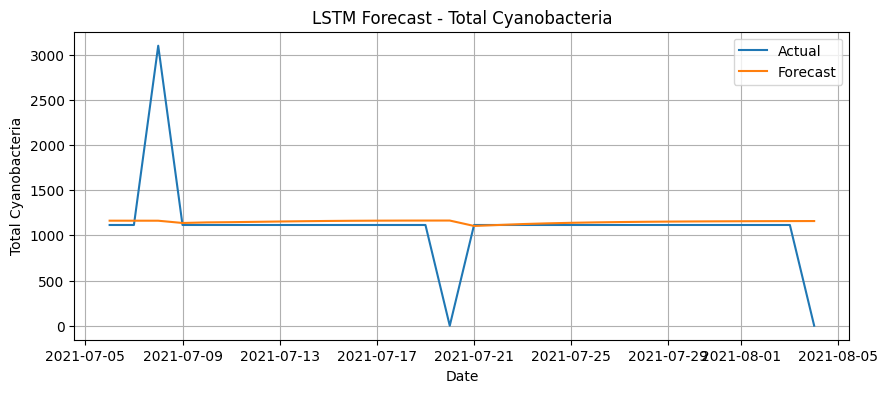

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


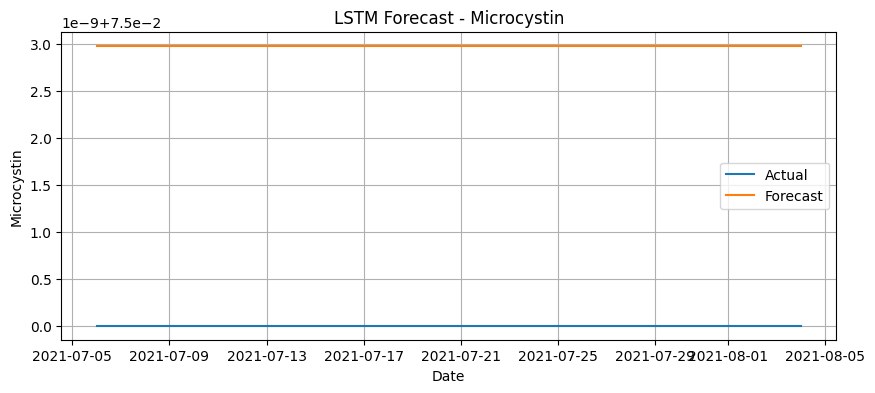

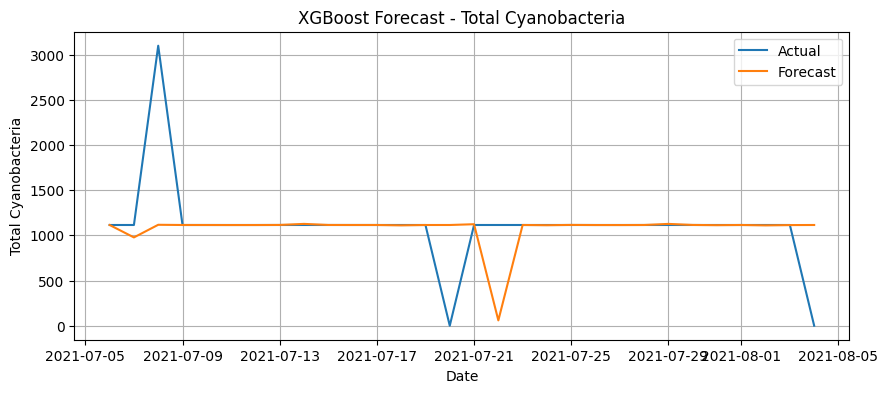

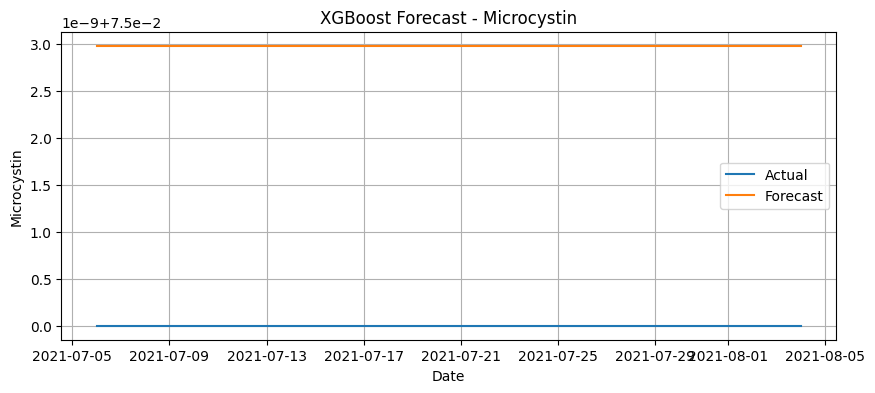

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5kzql6nf/p5pi6srq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5kzql6nf/cn4qc78g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25927', 'data', 'file=/tmp/tmp5kzql6nf/p5pi6srq.json', 'init=/tmp/tmp5kzql6nf/cn4qc78g.json', 'output', 'file=/tmp/tmp5kzql6nf/prophet_model6k3a8seq/prophet_model-20250421015910.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:59:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:59:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


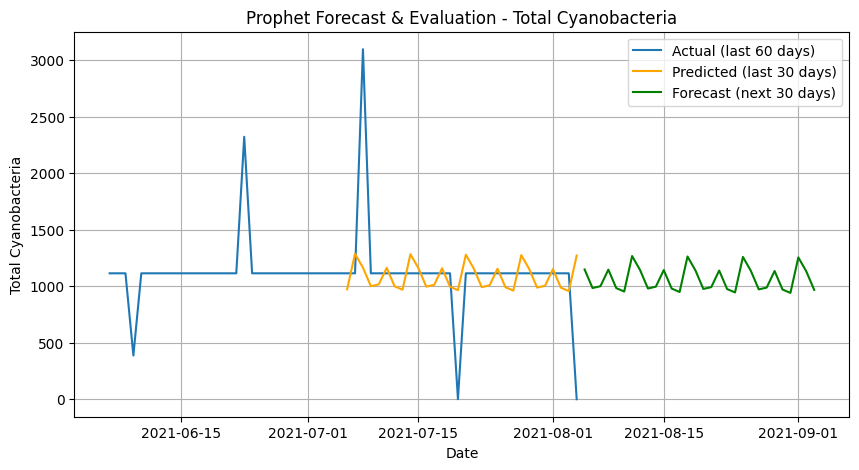

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


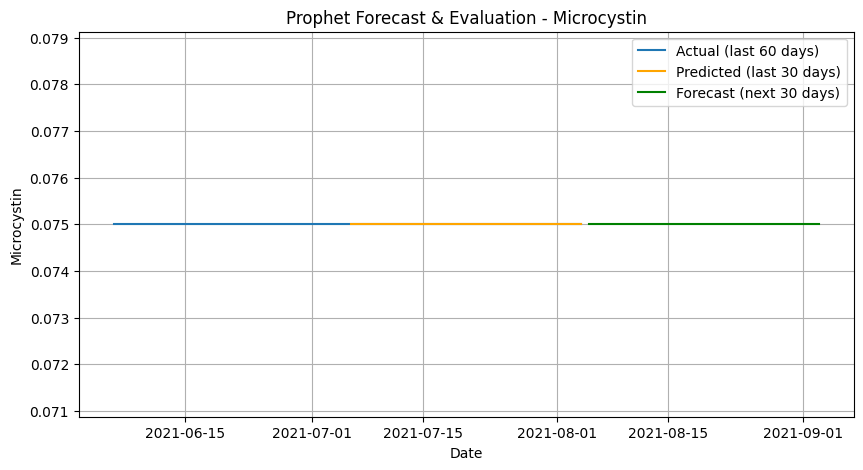


📊 Forecast Accuracy Summary:
     Model               Target           MAE          RMSE            R2
0     LSTM  Total Cyanobacteria  1.730595e+02  4.647965e+02 -1.006465e-02
1     LSTM          Microcystin  2.980232e-09  2.980232e-09 -4.611686e+16
2  XGBoost  Total Cyanobacteria  1.818312e+02  5.014170e+02 -1.754969e-01
3  XGBoost          Microcystin  2.980232e-09  2.980232e-09 -4.611686e+16
4  Prophet  Total Cyanobacteria  2.371187e+02  4.711634e+02 -3.792626e-02
5  Prophet          Microcystin  0.000000e+00  0.000000e+00  1.000000e+00

📈 Seasonal Summary: Total_Cyanobacteria
                    mean         std
season                              
Growing      1170.312005  770.012950
Non-Growing  1190.128023  778.625041


<Figure size 700x400 with 0 Axes>

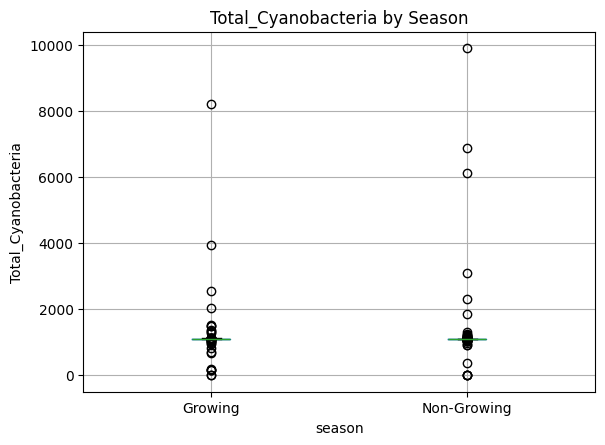


📈 Seasonal Summary: microcystin_total_abraxis_ugL
              mean           std
season                          
Growing      0.075  5.575198e-17
Non-Growing  0.075  3.476638e-16


<Figure size 700x400 with 0 Axes>

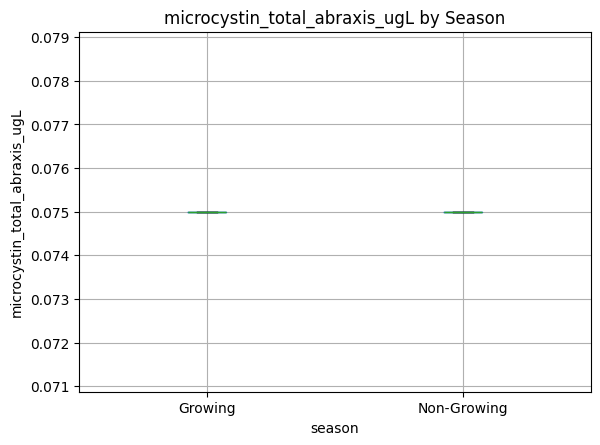

In [ ]:
# Full code for forecasting + evaluation + seasonal trend analysis at RR5 site

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import xgboost as xgb
from prophet import Prophet
import warnings
warnings.filterwarnings("ignore")

# Load dataset
path = "/content/drive/MyDrive/research_Mine/final_usgs_imputed_data_with_temperature.csv"
df = pd.read_csv(path, parse_dates=['dateTime'])
df_rr5 = df[df['site_abbreviation'] == 'RR5'].sort_values('dateTime').reset_index(drop=True)

results = []

# --- Helper Functions ---
def create_sequences(data, window_size=30):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

def forecast_lstm(target_col, label):
    series = df_rr5[[target_col, "dateTime"]].dropna()
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(series[[target_col]])

    X, y = create_sequences(scaled, 30)
    X = X.reshape((X.shape[0], X.shape[1], 1))

    split_idx = -30
    X_train, y_train = X[:split_idx], y[:split_idx]
    X_test, y_test = X[split_idx:], y[split_idx:]

    model = Sequential([LSTM(50, activation='relu', input_shape=(30, 1)), Dense(1)])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=50, verbose=0)

    y_pred_scaled = model.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred_scaled)
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1))

    mae = mean_absolute_error(y_test_inv, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred))
    r2 = r2_score(y_test_inv, y_pred)

    results.append({"Model": "LSTM", "Target": label, "MAE": mae, "RMSE": rmse, "R2": r2})

    plt.figure(figsize=(10,4))
    plt.plot(series["dateTime"].iloc[-30:], y_test_inv, label="Actual")
    plt.plot(series["dateTime"].iloc[-30:], y_pred, label="Forecast")
    plt.title(f"LSTM Forecast - {label}")
    plt.xlabel("Date")
    plt.ylabel(label)
    plt.legend()
    plt.grid(True)
    plt.show()
    return pd.DataFrame({
        "dateTime": series["dateTime"].iloc[-30:].values,
        "actual": y_test_inv.flatten(),
        "predicted": y_pred.flatten()
    })

def forecast_xgboost(target_col, label):
    series = df_rr5[["dateTime", target_col]].dropna().reset_index(drop=True)
    for lag in range(1, 31):
        series[f"lag_{lag}"] = series[target_col].shift(lag)
    series = series.dropna()

    train = series[:-30]
    test = series[-30:]
    X_train = train[[f"lag_{i}" for i in range(1,31)]]
    y_train = train[target_col]
    X_test = test[[f"lag_{i}" for i in range(1,31)]]
    y_test = test[target_col]

    model = xgb.XGBRegressor(n_estimators=100)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results.append({"Model": "XGBoost", "Target": label, "MAE": mae, "RMSE": rmse, "R2": r2})

    plt.figure(figsize=(10,4))
    plt.plot(test["dateTime"], y_test.values, label="Actual")
    plt.plot(test["dateTime"], y_pred, label="Forecast")
    plt.title(f"XGBoost Forecast - {label}")
    plt.xlabel("Date")
    plt.ylabel(label)
    plt.legend()
    plt.grid(True)
    plt.show()
    return pd.DataFrame({
        "dateTime": test["dateTime"].values,
        "actual": y_test.values,
        "predicted": y_pred
    })


def forecast_prophet(target_col, label):
    series = df_rr5[["dateTime", target_col]].dropna().rename(columns={"dateTime": "ds", target_col: "y"})
    model = Prophet()
    model.fit(series)

    # Create 30 future dates beyond the last date in the dataset
    future = model.make_future_dataframe(periods=30, freq='D')  # Covers all past + 30 future
    forecast = model.predict(future)

    # -------------------
    # Evaluate on last 30 actual days
    # -------------------
    actual = series.set_index("ds")
    predicted_full = forecast.set_index("ds")["yhat"]

    # Find last 30 overlapping actual dates
    eval_dates = actual.index[-30:]
    predicted_eval = predicted_full.loc[eval_dates]
    actual_eval = actual.loc[eval_dates, "y"]

    # Metrics
    mae = mean_absolute_error(actual_eval, predicted_eval)
    rmse = np.sqrt(mean_squared_error(actual_eval, predicted_eval))
    r2 = r2_score(actual_eval, predicted_eval)
    results.append({"Model": "Prophet", "Target": label, "MAE": mae, "RMSE": rmse, "R2": r2})

    # -------------------
    # Get future forecast (next 30 days)
    # -------------------
    last_date = actual.index.max()
    future_dates = forecast[forecast["ds"] > last_date][["ds", "yhat"]]

    # -------------------
    # Plot both
    # -------------------
    plt.figure(figsize=(10, 5))
    plt.plot(actual.index[-60:], actual["y"].iloc[-60:], label="Actual (last 60 days)")
    plt.plot(predicted_eval.index, predicted_eval, label="Predicted (last 30 days)", color="orange")
    plt.plot(future_dates["ds"], future_dates["yhat"], label="Forecast (next 30 days)", color="green")
    plt.title(f"Prophet Forecast & Evaluation - {label}")
    plt.xlabel("Date")
    plt.ylabel(label)
    plt.legend()
    plt.grid(True)
    plt.show()

    # Return both eval and future forecast
    return pd.DataFrame({
        "dateTime": predicted_eval.index.tolist() + future_dates["ds"].tolist(),
        "actual": actual_eval.tolist() + [np.nan] * len(future_dates),
        "predicted": predicted_eval.tolist() + future_dates["yhat"].tolist()
    })

# --- Run Forecasting for Both Targets ---
lstm_cyano_df = forecast_lstm("Total_Cyanobacteria", "Total Cyanobacteria")
lstm_micro_df = forecast_lstm("microcystin_total_abraxis_ugL", "Microcystin")

xgb_cyano_df = forecast_xgboost("Total_Cyanobacteria", "Total Cyanobacteria")
xgb_micro_df = forecast_xgboost("microcystin_total_abraxis_ugL", "Microcystin")

prophet_cyano_df = forecast_prophet("Total_Cyanobacteria", "Total Cyanobacteria")
prophet_micro_df = forecast_prophet("microcystin_total_abraxis_ugL", "Microcystin")

# Save to CSV if needed
lstm_cyano_df.to_csv("lstm_cyano_predictions.csv", index=False)
lstm_micro_df.to_csv("lstm_micro_predictions.csv", index=False)
xgb_cyano_df.to_csv("xgb_cyano_predictions.csv", index=False)
xgb_micro_df.to_csv("xgb_micro_predictions.csv", index=False)
prophet_cyano_df.to_csv("prophet_cyano_predictions.csv", index=False)
prophet_micro_df.to_csv("prophet_micro_predictions.csv", index=False)

# --- Accuracy Summary Table ---
results_df = pd.DataFrame(results)
print("\n📊 Forecast Accuracy Summary:")
print(results_df)

# --- Seasonal Trend Analysis ---
df_rr5["month"] = pd.to_datetime(df_rr5["dateTime"]).dt.month
growing = [5, 8, 10, 11]
df_rr5["season"] = df_rr5["month"].apply(lambda m: "Growing" if m in growing else "Non-Growing")

for col in ["Total_Cyanobacteria", "microcystin_total_abraxis_ugL"]:
    print(f"\n📈 Seasonal Summary: {col}")
    print(df_rr5.groupby("season")[col].describe()[["mean", "std"]])
    plt.figure(figsize=(7,4))
    df_rr5.boxplot(column=col, by="season")
    plt.title(f"{col} by Season")
    plt.suptitle("")
    plt.ylabel(col)
    plt.grid(True)
    plt.show()



📈 Seasonal Summary: Total_Cyanobacteria
                    mean         std
season                              
Growing      1170.312005  770.012950
Non-Growing  1190.128023  778.625041


<Figure size 700x400 with 0 Axes>

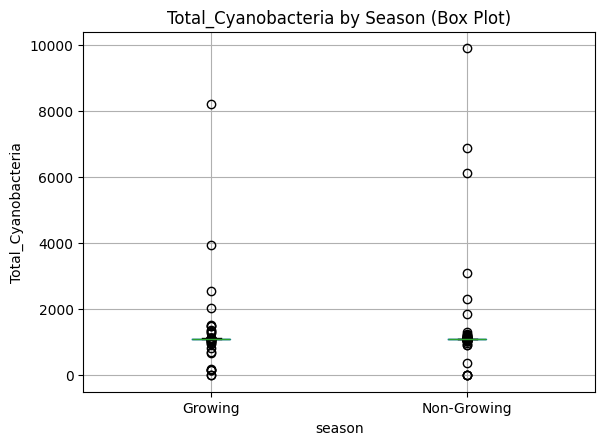

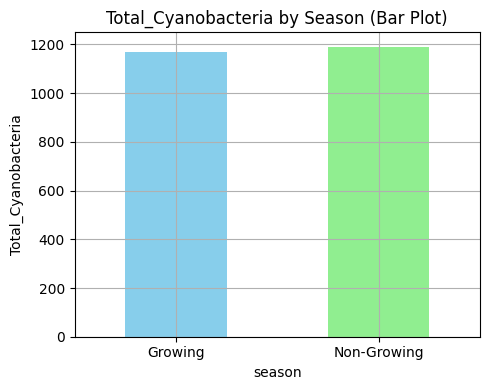


📈 Seasonal Summary: microcystin_total_abraxis_ugL
              mean           std
season                          
Growing      0.075  5.575198e-17
Non-Growing  0.075  3.476638e-16


<Figure size 700x400 with 0 Axes>

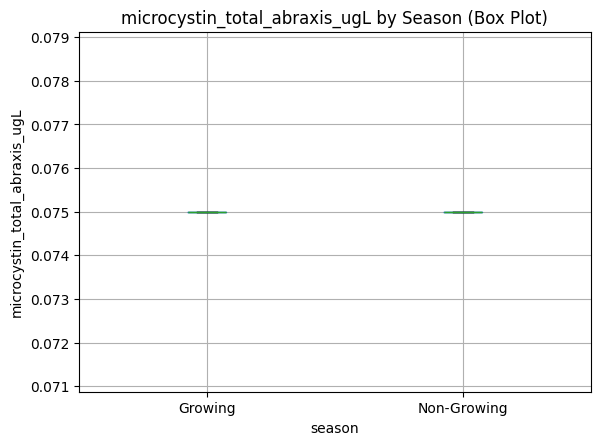

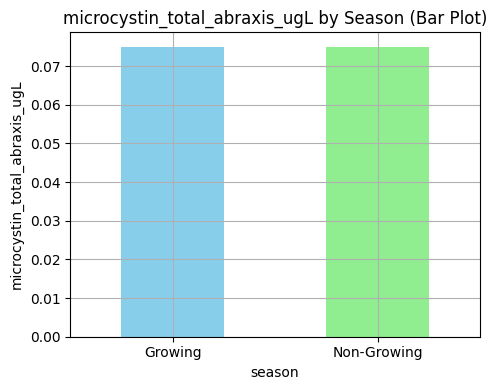

In [ ]:
# --- Seasonal Trend Analysis ---
df_rr5["month"] = pd.to_datetime(df_rr5["dateTime"]).dt.month
growing_months = [5, 8, 10, 11]
df_rr5["season"] = df_rr5["month"].apply(lambda m: "Growing" if m in growing_months else "Non-Growing")

for col in ["Total_Cyanobacteria", "microcystin_total_abraxis_ugL"]:
    print(f"\n📈 Seasonal Summary: {col}")
    print(df_rr5.groupby("season")[col].describe()[["mean", "std"]])

    # Box plots (existing visualization)
    plt.figure(figsize=(7, 4))
    df_rr5.boxplot(column=col, by="season")
    plt.title(f"{col} by Season (Box Plot)")
    plt.suptitle("")
    plt.ylabel(col)
    plt.grid(True)
    plt.show()

    # Bar plots (new visualization)
    seasonal_means = df_rr5.groupby("season")[col].mean()
    plt.figure(figsize=(5, 4))
    seasonal_means.plot(kind="bar", color=["skyblue", "lightgreen"])
    plt.title(f"{col} by Season (Bar Plot)")
    plt.ylabel(col)
    plt.xticks(rotation=0)  # Keep x-axis labels horizontal
    plt.grid(True)
    plt.tight_layout()
    plt.show()

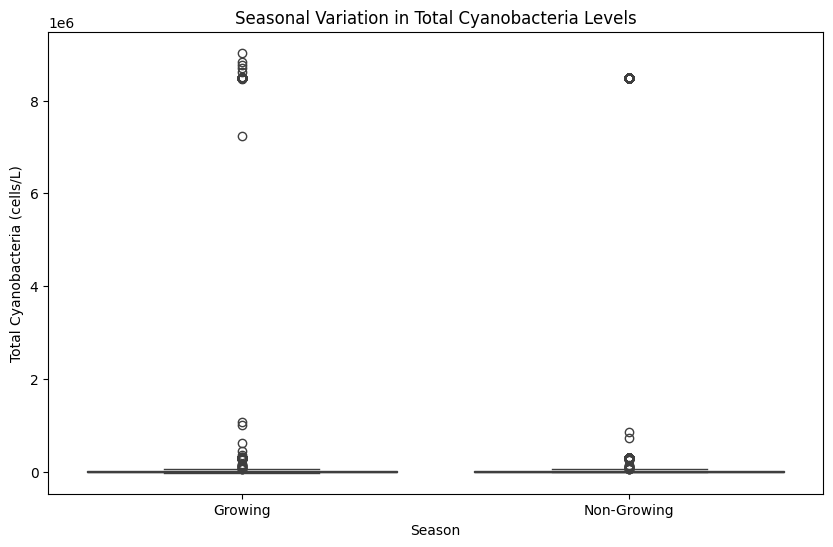

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert 'dateTime' to datetime format and create a 'Season' column
df['dateTime'] = pd.to_datetime(df['dateTime'])
df['Season'] = df['dateTime'].dt.month.apply(lambda x: 'Growing' if x in [5, 8, 10, 11] else 'Non-Growing')

# Plot Seasonal Boxplot for Total Cyanobacteria
plt.figure(figsize=(10, 6))
sns.boxplot(x='Season', y='Total_Cyanobacteria', data=df)
plt.title('Seasonal Variation in Total Cyanobacteria Levels')
plt.ylabel('Total Cyanobacteria (cells/L)')
plt.show()


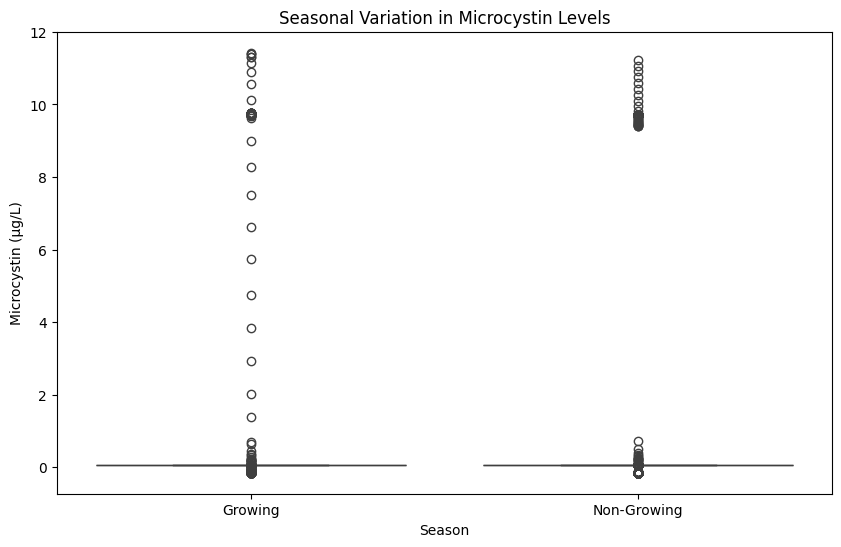

In [ ]:
# Plot Seasonal Boxplot for Microcystin
plt.figure(figsize=(10, 6))
sns.boxplot(x='Season', y='microcystin_total_abraxis_ugL', data=df)
plt.title('Seasonal Variation in Microcystin Levels')
plt.ylabel('Microcystin (µg/L)')
plt.show()


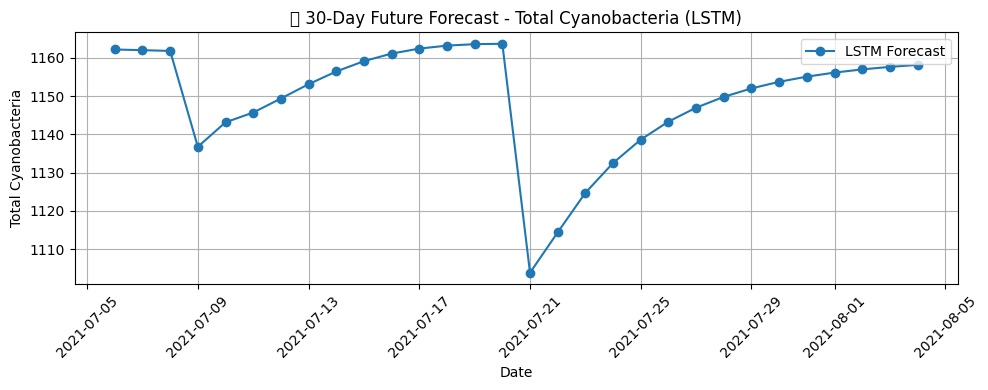

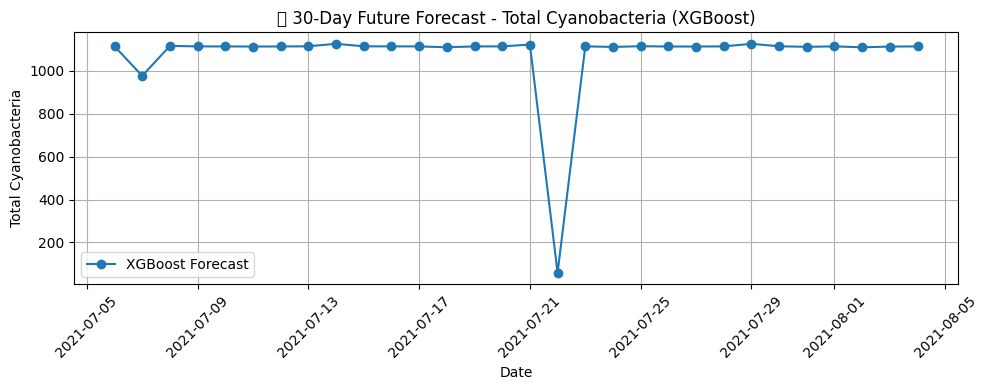

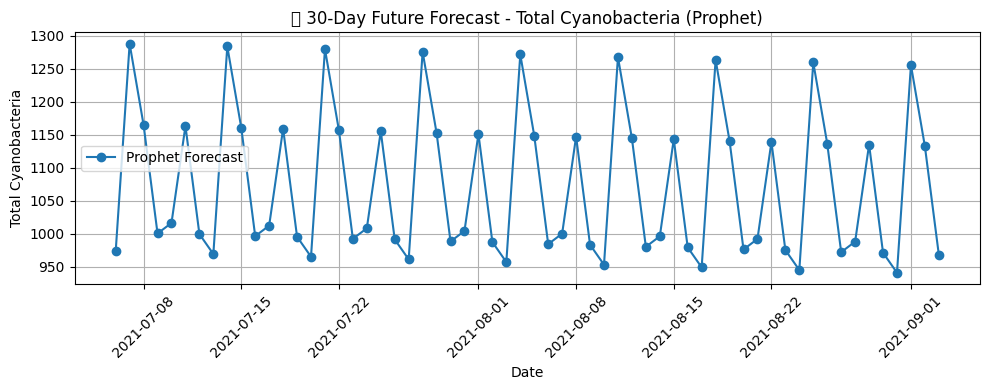

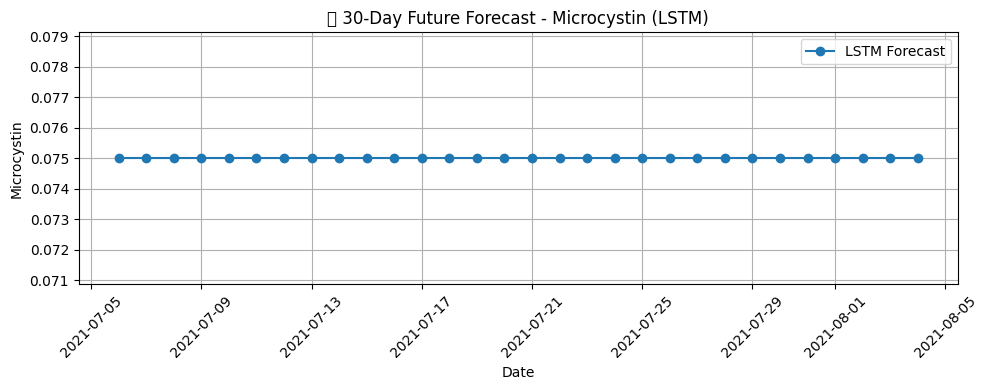

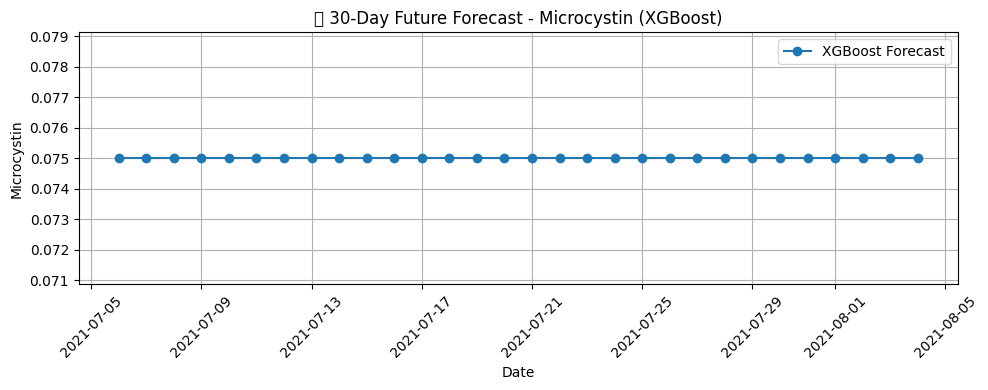

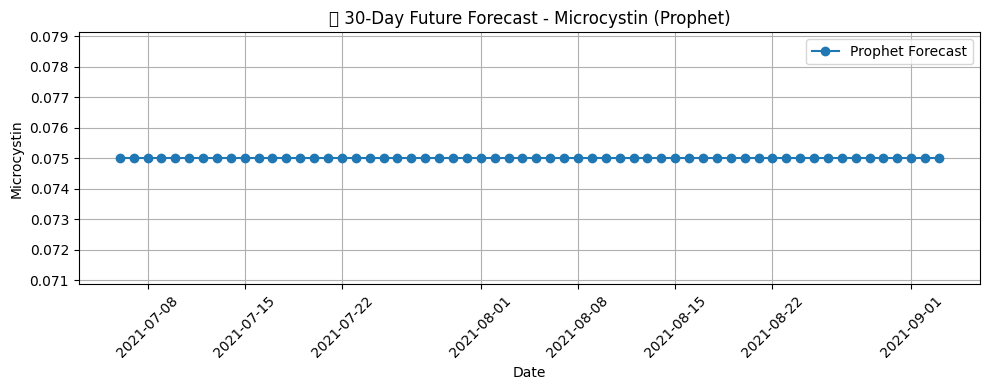

In [ ]:
import matplotlib.pyplot as plt

def plot_future_forecasts_only(pred_df, label, model_name):
    plt.figure(figsize=(10, 4))
    plt.plot(pred_df["dateTime"], pred_df["predicted"], marker='o', label=f"{model_name} Forecast")
    plt.title(f"📅 30-Day Future Forecast - {label} ({model_name})")
    plt.xlabel("Date")
    plt.ylabel(label)
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Visualize future predictions only
plot_future_forecasts_only(lstm_cyano_df, "Total Cyanobacteria", "LSTM")
plot_future_forecasts_only(xgb_cyano_df, "Total Cyanobacteria", "XGBoost")
plot_future_forecasts_only(prophet_cyano_df, "Total Cyanobacteria", "Prophet")

plot_future_forecasts_only(lstm_micro_df, "Microcystin", "LSTM")
plot_future_forecasts_only(xgb_micro_df, "Microcystin", "XGBoost")
plot_future_forecasts_only(prophet_micro_df, "Microcystin", "Prophet")


**Dashboard**

In [ ]:
!pip install streamlit
!pip install pyngrok

In [ ]:
!ngrok authtoken 'token'


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
public_url = ngrok.connect("8501")  # or replace 8501 with the correct port for your app
print(public_url)

NgrokTunnel: "https://fff3-34-16-180-23.ngrok-free.app" -> "http://localhost:8501"


In [ ]:
# Create Streamlit app script with dashboard code
code = '''
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt

# Load your prediction data
lstm_cyano_df = pd.read_csv("lstm_cyano_predictions.csv")
xgb_cyano_df = pd.read_csv("xgb_cyano_predictions.csv")
prophet_cyano_df = pd.read_csv("prophet_cyano_predictions.csv")

lstm_micro_df = pd.read_csv("lstm_micro_predictions.csv")
xgb_micro_df = pd.read_csv("xgb_micro_predictions.csv")
prophet_micro_df = pd.read_csv("prophet_micro_predictions.csv")

# Load the full dataset for season filtering
df_rr5 = pd.read_csv("/content/drive/MyDrive/research_Mine/final_usgs_imputed_data_with_temperature.csv")
df_rr5["dateTime"] = pd.to_datetime(df_rr5["dateTime"])
df_rr5["month"] = df_rr5["dateTime"].dt.month
growing = [5, 8, 10, 11]
df_rr5["season"] = df_rr5["month"].apply(lambda m: "Growing" if m in growing else "Non-Growing")

# Dashboard title
st.title("30-Day Future Forecast Dashboard")
st.subheader("Cyanobacteria and Microcystin Predictions by Season and Site")

# Option to select target variable (Cyanobacteria or Microcystin)
target_variable = st.selectbox(
    "Select Target Variable:",
    ["Total Cyanobacteria", "Microcystin"]
)

# Option to select site
site = st.selectbox(
    "Select Site:",
    df_rr5["site_abbreviation"].unique()
)

# Option to select season
season = st.selectbox(
    "Select Season:",
    ["Growing", "Non-Growing"]
)

# Option to select model
model = st.selectbox(
    "Select Forecast Model:",
    ["LSTM", "XGBoost", "Prophet"]
)

# Filter data for the selected site and season
filtered_df = df_rr5[(df_rr5["site_abbreviation"] == site) & (df_rr5["season"] == season)]

# Get the corresponding prediction data for the selected target variable
def plot_forecast(pred_df, label, model_name):
    plt.figure(figsize=(10, 4))
    plt.plot(pred_df["dateTime"], pred_df["predicted"], marker='o', label=f"{model_name} Forecast")
    plt.title(f"📅 30-Day Future Forecast - {label} ({model_name})")
    plt.xlabel("Date")
    plt.ylabel(label)
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    st.pyplot(plt)

# Display prediction for selected target variable, site, season, and model
if target_variable == "Total Cyanobacteria":
    if model == "LSTM":
        plot_forecast(lstm_cyano_df, "Total Cyanobacteria", "LSTM")
    elif model == "XGBoost":
        plot_forecast(xgb_cyano_df, "Total Cyanobacteria", "XGBoost")
    elif model == "Prophet":
        plot_forecast(prophet_cyano_df, "Total Cyanobacteria", "Prophet")

elif target_variable == "Microcystin":
    if model == "LSTM":
        plot_forecast(lstm_micro_df, "Microcystin", "LSTM")
    elif model == "XGBoost":
        plot_forecast(xgb_micro_df, "Microcystin", "XGBoost")
    elif model == "Prophet":
        plot_forecast(prophet_micro_df, "Microcystin", "Prophet")
'''

with open('forecast_dashboard.py', 'w') as f:
    f.write(code)

# Create a tunnel to the Streamlit app
from pyngrok import ngrok

public_url = ngrok.connect("8501")

# Run the Streamlit app
!streamlit run forecast_dashboard.py &

# Print the URL
print(f"Streamlit app is live at: {public_url}")




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.16.180.23:8501

/usr/local/lib/python3.11/dist-packages/streamlit/elements/pyplot.py:176: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) DejaVu Sans.
  fig.savefig(image, **kwargs)
/usr/local/lib/python3.11/dist-packages/streamlit/elements/pyplot.py:176: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) DejaVu Sans.
  fig.savefig(image, **kwargs)
/usr/local/lib/python3.11/dist-packages/streamlit/elements/pyplot.py:176: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) DejaVu Sans.
  fig.savefig(image, **kwargs)
/usr/local/lib/python3.11/dist-packages/streamlit/elements/pyplot.py:176: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) DejaVu Sans.
  fig.savefig(image, **kwargs)
/usr/local/lib/python3.11/dist-packages/streamlit/elements/pyplot.py:176: UserWarning: Glyph 128197 (\N{C